In [1]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.util.img_processing import resize_img
from heeps.util.freq_decomp import get_zernike, psd_spatial_zernike, psd_temporal
from copy import deepcopy
import numpy as np
import os.path
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Input parameters

In [2]:
nzer = 100
nimg = 720
duration = 3600
samp_wv = 100               # wv sampling in ms
samp_scao = 300             # scao sampling in ms
step = int(samp_scao/samp_wv)
diam_ext = 36.905e9         # external diameter in nm
nm2mas = 4/diam_ext*u.rad.to('mas')
temporal_rms = 8814.1
scaling_L = 50/temporal_rms
scaling_N = 600/temporal_rms
print('scaling_L=%s, scaling_N=%s'%(np.round(scaling_L,3), np.round(scaling_N,3)))
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
print('npupil_L=%s, npupil_N=%s'%(npupil_L, npupil_N))
ncube_psd = 100             # number of frames for PSD
nzer_psd = 20               # number of Z modes for PSD
np.random.seed(13579)
# rainbow map colors
colors = np.array([cm.rainbow(i) for i in np.linspace(0, 1, nzer_psd)])

scaling_L=0.006, scaling_N=0.068
npupil_L=285, npupil_N=119


In [3]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/wavefront')))
scao = 'cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_%s_%s_%s.fits'
pup_scao = fits.getdata('cfull/mask_Cfull_20211007_L_285.fits')
pup_scao[pup_scao < .5] = 0
wv = 'wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV.fits'
pup_wv = fits.getdata('wv/mask_Cbasic_20210601_720.fits')
pup_wv[pup_wv < .5] = 0
# pup should NOT have NANs for prop_fit_zernikes

In [4]:
def plot_tpsd(y1, label1, y2, label2, title, z=[1,2,3,4,8,12,16,20], man_colors=None):
    x = np.arange(y1.shape[1])/duration
    plt.figure(figsize=(12,6))
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    for ys, label, ls in zip([y1, y2], [label1, label2], ['-', ':']):
        for i, y in enumerate(ys):
            if i+1 in z:
                if man_colors == None:
                    color = 'k' if i==0 else colors[i-1]
                else:
                    color = man_colors[i]
                plt.loglog(x, y, color=color, label='Z%s %s'%(i+1, label), linestyle=ls)
    plt.legend(ncol=2, fontsize='small')
    plt.xlim((1e-2, max(x)))
    plt.ylim((1e3, 1e11))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Temporal PSD [nm^2/Hz]');

def get_zpols_roll(zpols, nLF, nHF):
    zpols_roll_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s.fits'%(nzer, nLF, nHF)
    if os.path.isfile(zpols_roll_name):
        print('already exists: ' + zpols_roll_name)
    else:
        print('write to ' + zpols_roll_name)
        zpols_roll = deepcopy(zpols)
        for i in range(len(zpols_roll)):
            end = max(i, 1)
            start = max(i-nLF, 0)
            zpols_roll[i,1:3] = np.mean(zpols[start:end,1:3], 0)
            start = max(i-nHF, 0)
            zpols_roll[i,3:] = np.mean(zpols[start:end,3:], 0)
        fits.writeto(zpols_roll_name, np.float32(zpols_roll))

def get_zpols_integ(zpols, nLF, nHF, G):
    zpols_integ_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s_G_%s.fits'%(nzer, nLF, nHF, G)
    if os.path.isfile(zpols_integ_name):
        print('already exists: ' + zpols_integ_name)
    else:
        print('write to ' + zpols_integ_name)
        zpols_integ = np.zeros(zpols.shape)
        nframes = len(zpols)
        # piston
        zpols_integ[:,0] = zpols[:,0]
        # tip-tilt, and higher modes
        for m, freq in zip([range(1,3), range(3,nzer)], [nLF, nHF]):
            for n in range(freq, nframes, freq):
                zpols_integ[n:n+freq,m] = zpols_integ[n-1,m] + G*np.mean(zpols[n-freq:n,m] - zpols_integ[n-1,m], 0)
        fits.writeto(zpols_integ_name, np.float32(zpols_integ))

def get_zpols_integ_lag(zpols, nLF, nHF, G, lag):
    zpols_integ_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s_G_%s_lag_%s.fits'%(nzer, nLF, nHF, G, lag)
    if os.path.isfile(zpols_integ_name):
        print('already exists: ' + zpols_integ_name)
    else:
        print('write to ' + zpols_integ_name)
        zpols_integ = np.zeros(zpols.shape)
        nframes = len(zpols)
        # piston
        zpols_integ[:,0] = zpols[:,0]
        # tip-tilt, and higher modes
        for m, freq in zip([range(1,3), range(3,nzer)], [nLF, nHF]):
            for n in range(freq +lag, nframes, freq):
                zpols_integ[n:n+freq,m] = zpols_integ[n-1,m] + G*np.mean(zpols[n-freq-lag:n-lag,m] - zpols_integ[n-1,m], 0)
        fits.writeto(zpols_integ_name, np.float32(zpols_integ))
        
def get_zpols_integ_scaled(zpols, band, nLF, nHF, G, S):
    if band == 'L':
        scaling = scaling_L*1e9
    elif band == 'N':
        scaling = scaling_N*1e9
    zpols_integ_name = wv[:-5] + '%s_zpols_%s_nLF_%s_nHF_%s_G_%s_S_%s.fits'%(band, nzer, nLF, nHF, G, S)
    if os.path.isfile(zpols_integ_name):
        print('already exists: ' + zpols_integ_name)
    else:
        print('write to ' + zpols_integ_name)
        Z = zpols*scaling
        X = np.zeros(Z.shape)
        nframes = len(Z)
        # piston
        X[:,0] = Z[:,0]
        # tip-tilt, and higher modes
        for m, freq in zip([range(1,3), range(3,nzer)], [nLF, nHF]):
            for n in range(freq, nframes, freq):
                #S_ratio = Z[n-freq:n,m]**2/np.sum(Z[n-freq:n,m]**2, 1)
                error = np.mean(Z[n-freq:n,m] - X[n-1,m] + np.random.normal(0, S, (freq,len(m))), 0) 
                X[n:n+freq,m] = X[n-1,m] + G*error
        fits.writeto(zpols_integ_name, np.float32(X))

def plot_integ(nframes, zmodes, band, nLF=1, nHF=10, Gs=[.2,.4,.6,.8,1], yunits='nm'):
    if band == 'L':
        scaling = scaling_L*1e9
    elif band == 'N':
        scaling = scaling_N*1e9
    Z = zpols[:,zmodes]*scaling
    if yunits == 'mas':
        Z *= nm2mas
    ts = np.arange(nframes)*samp_wv/1e3
    _, (a0, a1) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    a0.plot(ts, np.sqrt(np.sum(Z[:nframes]**2,1)), label='error signal', color='k', linestyle='--')
    for G in Gs:
        zpols_integ_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s_G_%s.fits'%(nzer, nLF, nHF, G)
        X = fits.getdata(zpols_integ_name)[:,zmodes]*scaling
        if yunits == 'mas':
            X *= nm2mas
        Y = Z - X
        Xrms = np.sqrt(np.sum(X**2,1))
        Yrms = np.sqrt(np.sum(Y**2,1))
        a0.plot(ts, Xrms[:nframes], label='G = %s'%G)
        a1.plot(ts, Yrms[:nframes], label='$\mu = %3.2f %s, \sigma = %3.2f %s$'\
                %(np.mean(Yrms), yunits, np.std(Yrms), yunits))
    a0.set_title('correction at %s band'%band)
    a0.set_ylabel('RMS WFE (%s)'%yunits)
    a0.legend(loc='lower right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a1.set_title('residual error at %s band'%band)
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('RMS WFE (%s)'%yunits)
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]));

def plot_integ_noise(nframes, zmodes, band, nLF=1, nHF=1, G=.4, Ss=[0,2,4,6,8,10], yunits='nm'):
    if band == 'L':
        scaling = scaling_L*1e9
    elif band == 'N':
        scaling = scaling_N*1e9
    Z = zpols[:,zmodes]*scaling
    if yunits == 'mas':
        Z *= nm2mas
    ts = np.arange(nframes)*samp_wv/1e3
    _, (a0, a1) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    a0.plot(ts, np.sqrt(np.sum(Z[:nframes]**2,1)), label='error signal', color='k', linestyle='--')
    for S in Ss:
        zpols_integ_name = wv[:-5] + '%s_zpols_%s_nLF_%s_nHF_%s_G_%s_S_%s.fits'%(band, nzer, nLF, nHF, G, S)
        X = fits.getdata(zpols_integ_name)[:,zmodes] # already rescaled
        if yunits == 'mas':
            X *= nm2mas
        Y = Z - X
        Xrms = np.sqrt(np.sum(X**2,1))
        Yrms = np.sqrt(np.sum(Y**2,1))
        a0.plot(ts, Xrms[:nframes], label='noise = %s nm rms'%S)
        a1.plot(ts, Yrms[:nframes], label='$\mu = %3.2f %s, \sigma = %3.2f %s$'\
                %(np.mean(Yrms), yunits, np.std(Yrms), yunits))
    a0.set_title('correction at %s band'%band)
    a0.set_ylabel('RMS WFE (%s)'%yunits)
    a0.legend(loc='lower right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a1.set_title('residual error at %s band'%band)
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('RMS WFE (%s)'%yunits)
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]));
    
def plot_integ_lag(nframes, zmodes, band, nLF=1, nHF=1, G=.4, lags=[0, 5, 10, 15, 20, 25, 30], yunits='nm'):
    if band == 'L':
        scaling = scaling_L*1e9
    elif band == 'N':
        scaling = scaling_N*1e9
    Z = zpols[:,zmodes]*scaling
    if yunits == 'mas':
        Z *= nm2mas
    ts = np.arange(nframes)*samp_wv/1e3
    _, (a0, a1) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    a0.plot(ts, np.sqrt(np.sum(Z[:nframes]**2,1)), label='error signal', color='k', linestyle='--')
    for lag in lags:
        zpols_integ_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s_G_%s_lag_%s.fits'%(nzer, nLF, nHF, G, lag)
        X = fits.getdata(zpols_integ_name)[:,zmodes]*scaling
        if yunits == 'mas':
            X *= nm2mas
        Y = Z - X
        Xrms = np.sqrt(np.sum(X**2,1))
        Yrms = np.sqrt(np.sum(Y**2,1))
        a0.plot(ts, Xrms[:nframes], label='lag = %s ms'%(100*lag))
        a1.plot(ts, Yrms[:nframes], label='$\mu = %3.2f %s, \sigma = %3.2f %s$'\
                %(np.mean(Yrms), yunits, np.std(Yrms), yunits))
    a0.set_title('correction at %s band'%band)
    a0.set_ylabel('RMS WFE (%s)'%yunits)
    a0.legend(loc='lower right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a1.set_title('residual error at %s band'%band)
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('RMS WFE (%s)'%yunits)
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]));

# 1/ Water vapor with no correction
### Spatial PSD

getdata wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100.fits
getdata wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_spsd_20.fits


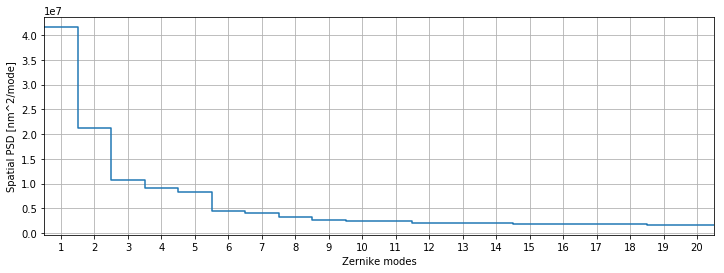

In [5]:
zpols = get_zernike(wv, pup_wv, nzer)
spsd = psd_spatial_zernike(wv, pup_wv, zpols, nzer_psd, ncube_psd)*1e9**2
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
x = np.arange(nzer_psd + 1) + .5
plt.plot(x, spsd, ls='steps')
plt.xlabel('Zernike modes')
plt.ylabel('Spatial PSD [nm^2/mode]')
plt.xlim((.5, nzer_psd + .5))
plt.xticks(np.arange(nzer_psd) + 1);

### One frame example

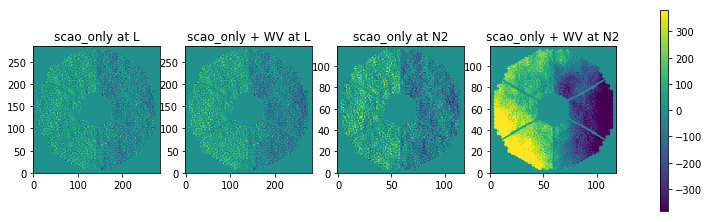

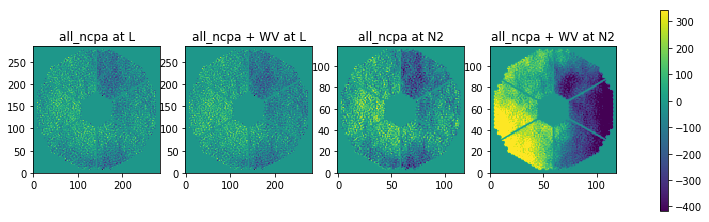

In [6]:
i = 20 # frame number
j = step*i
for case in ['scao_only', 'all_ncpa']:
    scao_L = fits.getdata(scao%(case,'L',npupil_L))[i]*1e9
    scao_N = fits.getdata(scao%(case,'N2',npupil_N))[i]*1e9
    wv_L = resize_img(fits.getdata(wv)[j], npupil_L)*(scaling_L*1e9)
    wv_N = resize_img(fits.getdata(wv)[j], npupil_N)*(scaling_N*1e9)
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
    plt.subplot(141); plt.title('%s at L'%case)
    im = plt.imshow(scao_L, origin='lower')
    vmin, vmax = plt.gci().get_clim()
    plt.subplot(142); plt.title('%s + WV at L'%case)
    plt.imshow(scao_L + wv_L, origin='lower', vmin=vmin, vmax=vmax)
    plt.subplot(143); plt.title('%s at N2'%case)
    im = plt.imshow(scao_N, origin='lower')
    plt.subplot(144); plt.title('%s + WV at N2'%case)
    plt.imshow(scao_N + wv_N, origin='lower', vmin=vmin, vmax=vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

### Zernike fitting

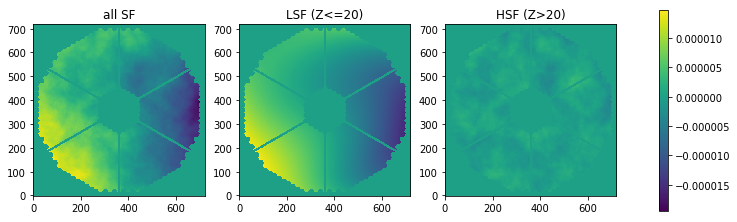

In [7]:
spsd_name = wv[:-5] + '_%s' + '_%s.fits'%nzer_psd
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.subplot(131); im = plt.imshow(fits.getdata(wv)[j], origin='lower'); plt.title('all SF')
vmin, vmax = plt.gci().get_clim()
plt.subplot(132); plt.title('LSF (Z<=%s)'%nzer_psd)
plt.imshow(fits.getdata(spsd_name%'LSFs')[-1,j], origin='lower', vmin=vmin, vmax=vmax)
plt.subplot(133); plt.title('HSF (Z>%s)'%nzer_psd)
plt.imshow(fits.getdata(spsd_name%'HSFs')[-1,j], origin='lower', vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax);

### Temporal PSD

getdata cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285_zpols_100.fits
getdata wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100.fits


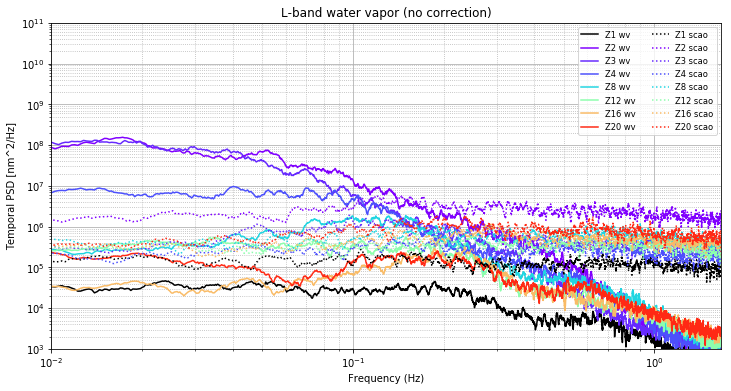

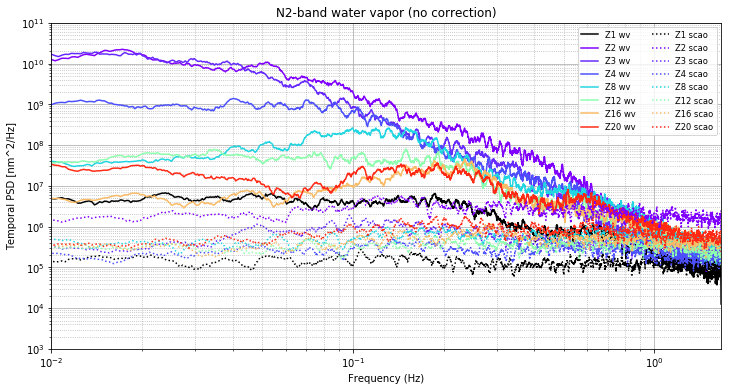

In [8]:
tpsd_scao = psd_temporal(get_zernike(scao%('scao_only','L',npupil_L), pup_scao, nzer)[:,:nzer_psd])*1e9**2
tpsd_wv = psd_temporal(get_zernike(wv, pup_wv, nzer)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*scaling_L**2
tpsd_wvn = tpsd_wv*scaling_N**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band water vapor (no correction)')
plot_tpsd(tpsd_wvn, 'wv', tpsd_scao, 'scao', 'N2-band water vapor (no correction)')

# 2/ Rolling average correction

In [9]:
freqs = [(1,1), (1,10), (1,100)]
for nLF, nHF in freqs:
    get_zpols_roll(zpols, nLF, nHF)

already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_100.fits


### Temporal PSD

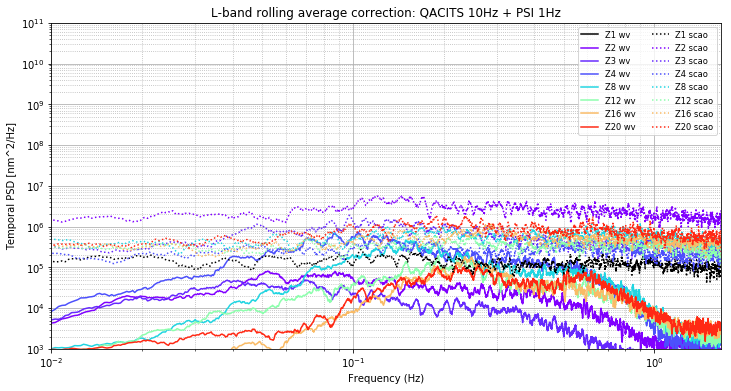

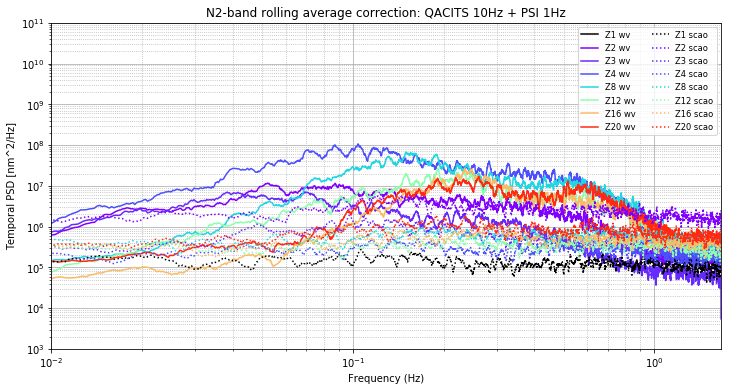

In [10]:
zpols_roll_1 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_1.fits')
zpols_roll_10 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_10.fits')
zpols_roll_100 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_100.fits')
tpsd_wv = psd_temporal((zpols - zpols_roll_10)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*scaling_L**2
tpsd_wvn = tpsd_wv*scaling_N**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band rolling average correction: QACITS 10Hz + PSI 1Hz')
plot_tpsd(tpsd_wvn, 'wv', tpsd_scao, 'scao', 'N2-band rolling average correction: QACITS 10Hz + PSI 1Hz')

### WFE for Zernikes 4-100

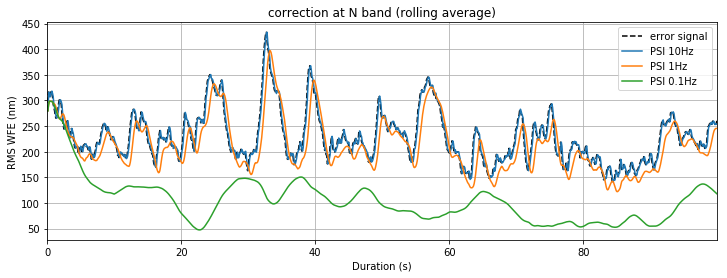

In [11]:
scaling = scaling_N*1e9
nframes = 1000
ts = np.arange(nframes)*samp_wv/1e3
m = range(3,nzer)
plt.figure(figsize=(12,4))
plt.plot(ts, np.sqrt(np.sum(zpols[:nframes,m]**2,1))*scaling, label='error signal', color='k', linestyle='--')
plt.plot(ts, np.sqrt(np.sum(zpols_roll_1[:nframes,m]**2,1))*scaling, label='PSI 10Hz')
plt.plot(ts, np.sqrt(np.sum(zpols_roll_10[:nframes,m]**2,1))*scaling, label='PSI 1Hz')
plt.plot(ts, np.sqrt(np.sum(zpols_roll_100[:nframes,m]**2,1))*scaling, label='PSI 0.1Hz')
plt.legend(); plt.grid('on')
plt.title('correction at N band (rolling average)')
plt.xlabel('Duration (s)')
plt.ylabel('RMS WFE (nm)')
plt.xlim((0, ts[-1]));

# 3/ Closed-loop control with an integrator

In [12]:
for G in [.2, .4, .6, .8, 1]:
    get_zpols_integ(zpols, 1, 1, G)
    get_zpols_integ(zpols, 1, 10, G)
    get_zpols_integ(zpols, 3, 3, G)
    get_zpols_integ(zpols, 10, 10, G)

already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1_G_0.2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_0.2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_3_nHF_3_G_0.2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_10_nHF_10_G_0.2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1_G_0.4.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_0.4.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_3_nHF_3_G_0.4.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_10_nHF_10_G_0.4.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0pisto

### Temporal PSD for QACITS

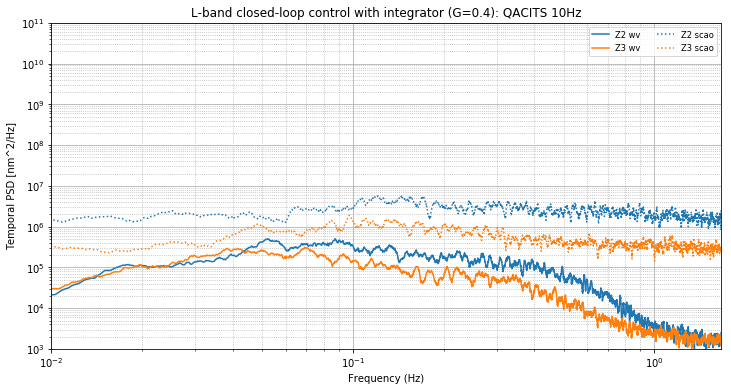

In [13]:
zpols_integ_04 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_10_G_0.4.fits')
tpsd_wv = psd_temporal((zpols - zpols_integ_04)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*scaling_L**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band closed-loop control with integrator (G=0.4): QACITS 10Hz',
          z=[2,3], man_colors=['k','C0','C1'])

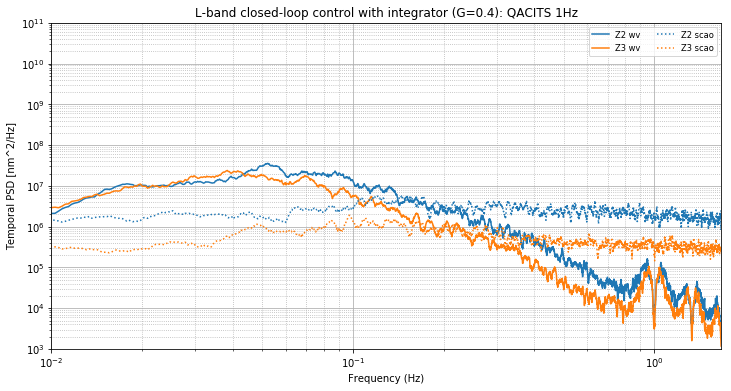

In [14]:
zpols_integ_04 = fits.getdata(wv[:-5] + '_zpols_100_nLF_10_nHF_10_G_0.4.fits')
tpsd_wv = psd_temporal((zpols - zpols_integ_04)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*scaling_L**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band closed-loop control with integrator (G=0.4): QACITS 1Hz',
          z=[2,3], man_colors=['k','C0','C1'])

### Temporal PSD for PSI

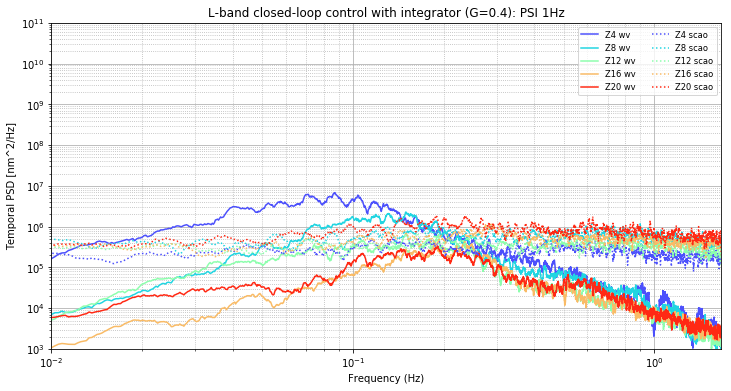

In [15]:
zpols_integ_04 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_10_G_0.4.fits')
tpsd_wv = psd_temporal((zpols - zpols_integ_04)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*scaling_L**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band closed-loop control with integrator (G=0.4): PSI 1Hz',
          z=[4,8,12,16,20])

### Tip-tilt at 10 Hz

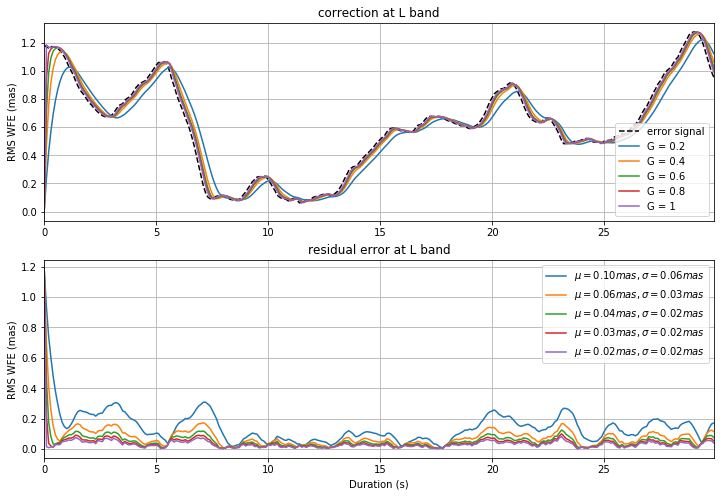

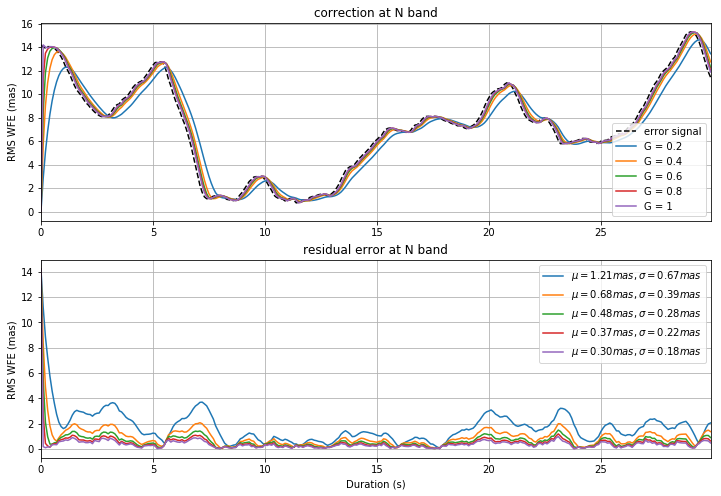

In [16]:
nframes = 300
plot_integ(nframes, range(1,3), 'L', nLF=1, nHF=1, yunits='mas')
plot_integ(nframes, range(1,3), 'N', nLF=1, nHF=1, yunits='mas')

### Tip-tilt at 3.33 Hz

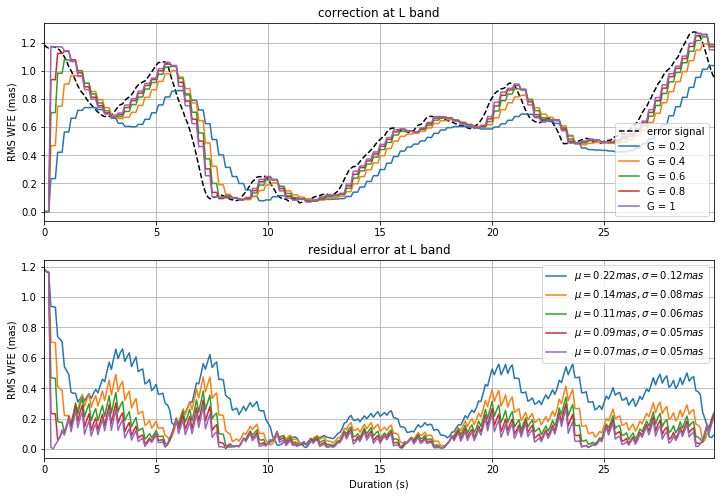

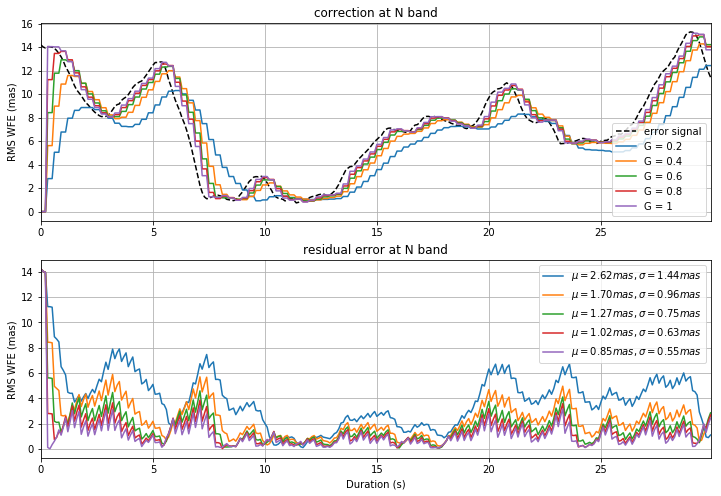

In [17]:
plot_integ(nframes, range(1,3), 'L', nLF=3, nHF=3, yunits='mas')
plot_integ(nframes, range(1,3), 'N', nLF=3, nHF=3, yunits='mas')

### Tip-tilt at 1 Hz

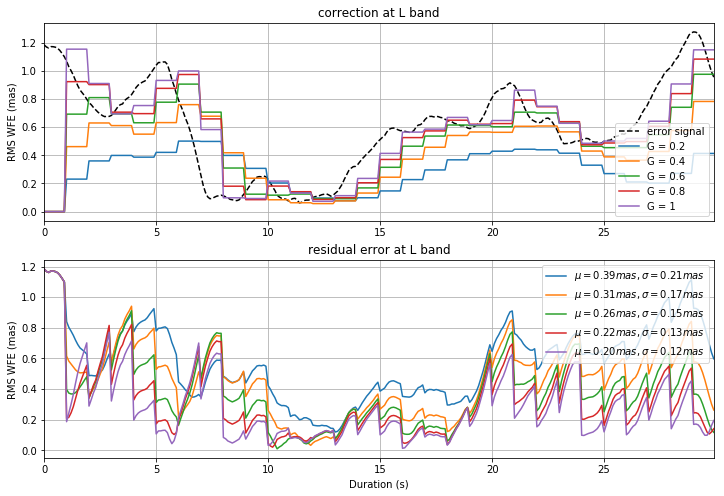

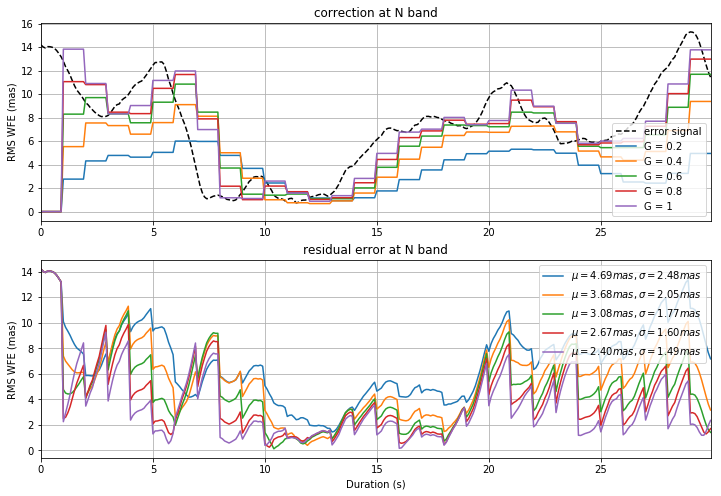

In [18]:
plot_integ(nframes, range(1,3), 'L', nLF=10, nHF=10, yunits='mas')
plot_integ(nframes, range(1,3), 'N', nLF=10, nHF=10, yunits='mas')

### Zernikes 4-100 at 10 Hz

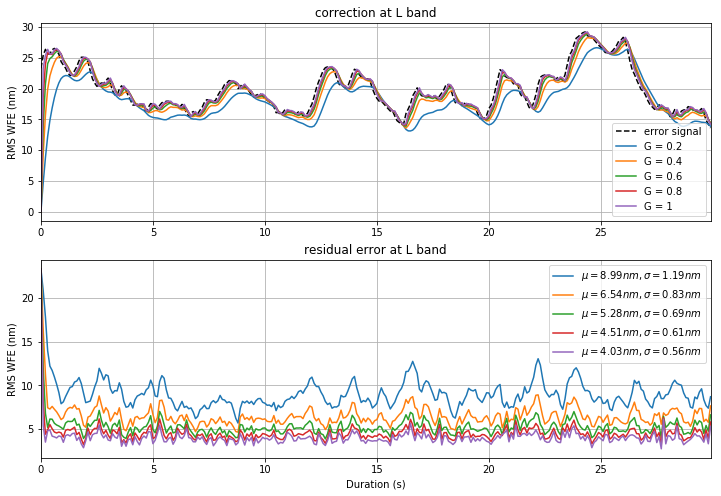

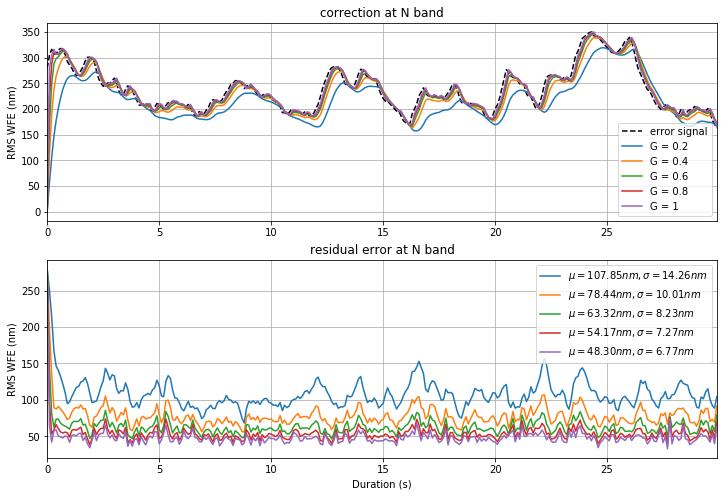

In [19]:
plot_integ(nframes, range(3,nzer), 'L', nLF=1, nHF=1)
plot_integ(nframes, range(3,nzer), 'N', nLF=1, nHF=1)

### Zernikes 4-100 at 3.33 Hz

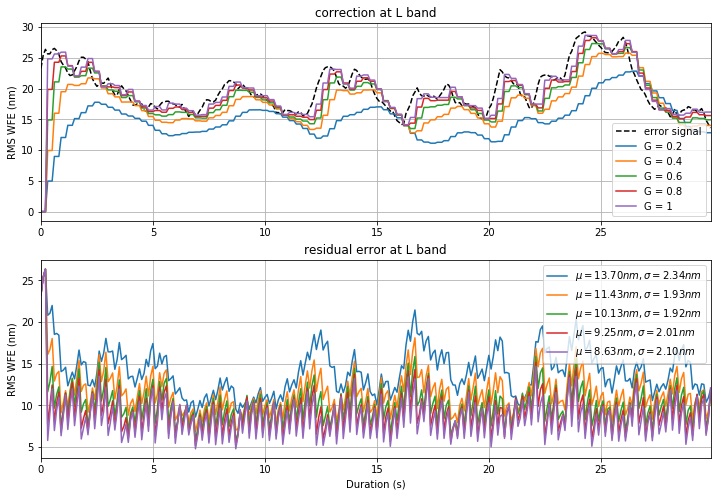

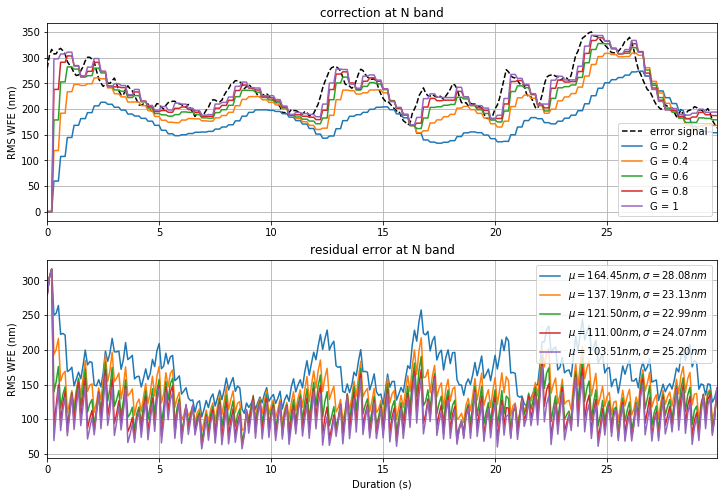

In [20]:
plot_integ(nframes, range(3,nzer), 'L', nLF=3, nHF=3)
plot_integ(nframes, range(3,nzer), 'N', nLF=3, nHF=3)

### Zernikes 4-100 at 1 Hz

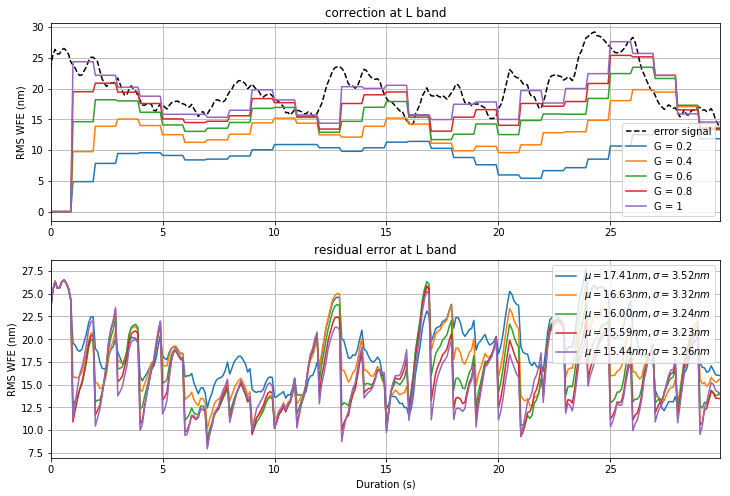

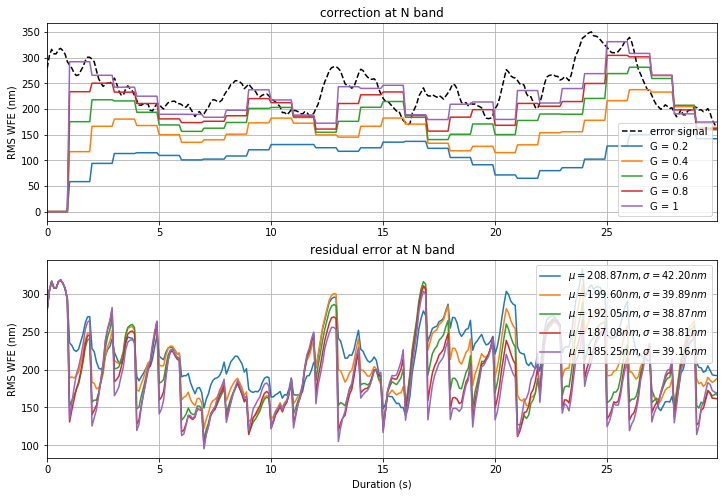

In [21]:
plot_integ(nframes, range(3,nzer), 'L', nLF=10, nHF=10)
plot_integ(nframes, range(3,nzer), 'N', nLF=10, nHF=10)

# 4/ Closed-loop + gaussian noise

In [22]:
for S in [0, 2, 4, 6, 8, 10]:
    get_zpols_integ_scaled(zpols, 'L', 1, 1, 0.4, S)
    get_zpols_integ_scaled(zpols, 'L', 3, 3, 0.4, S)
    get_zpols_integ_scaled(zpols, 'L', 10, 10, 0.4, S)

already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_1_nHF_1_G_0.4_S_0.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_3_nHF_3_G_0.4_S_0.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_10_nHF_10_G_0.4_S_0.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_1_nHF_1_G_0.4_S_2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_3_nHF_3_G_0.4_S_2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_10_nHF_10_G_0.4_S_2.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_1_nHF_1_G_0.4_S_4.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WVL_zpols_100_nLF_3_nHF_3_G_0.4_S_4.fits
already exists: wv/c

### Tip-tilt at 10 Hz (G = 0.4)

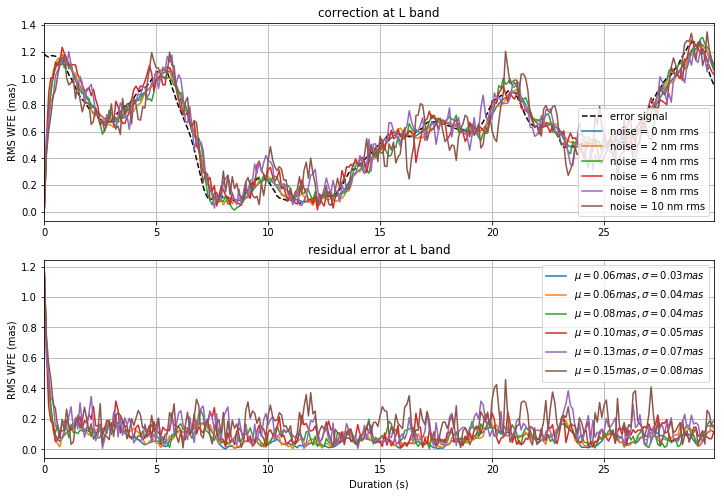

In [23]:
plot_integ_noise(nframes, range(1,3), 'L', nLF=1, nHF=1, G=.4, yunits='mas')

### Tip-tilt at 3.33 Hz (G = 0.4)

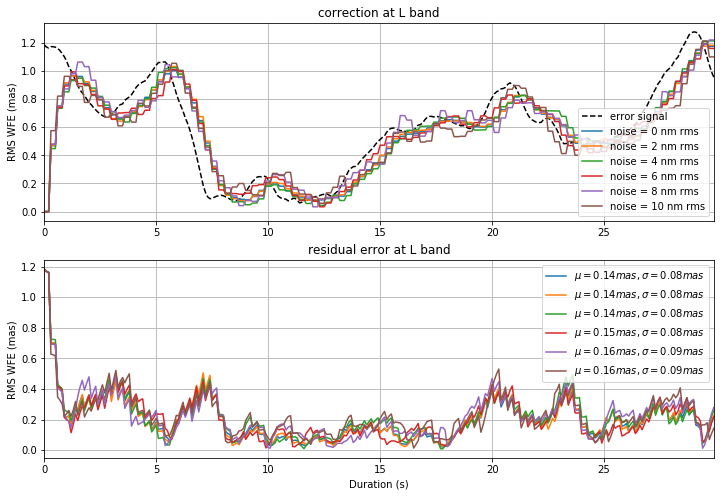

In [24]:
plot_integ_noise(nframes, range(1,3), 'L', nLF=3, nHF=3, G=.4, yunits='mas')

### Tip-tilt at 1 Hz (G = 0.4)

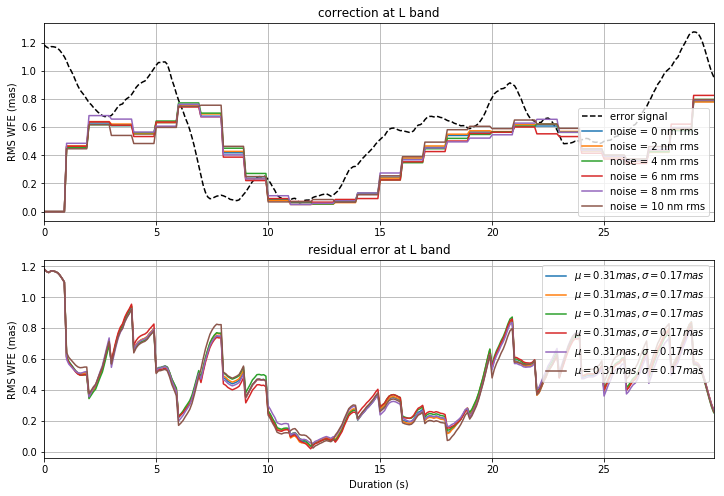

In [25]:
plot_integ_noise(nframes, range(1,3), 'L', nLF=10, nHF=10, G=.4, yunits='mas')

### Zernikes 4-100 at 10 Hz (G = 0.4)

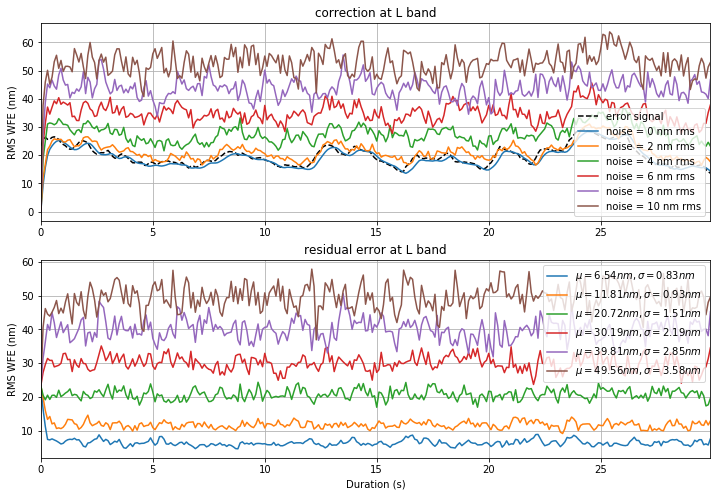

In [26]:
plot_integ_noise(nframes, range(3,100), 'L', nLF=1, nHF=1, G=.4)

### Zernikes 4-100 at 3.33 Hz (G = 0.4)

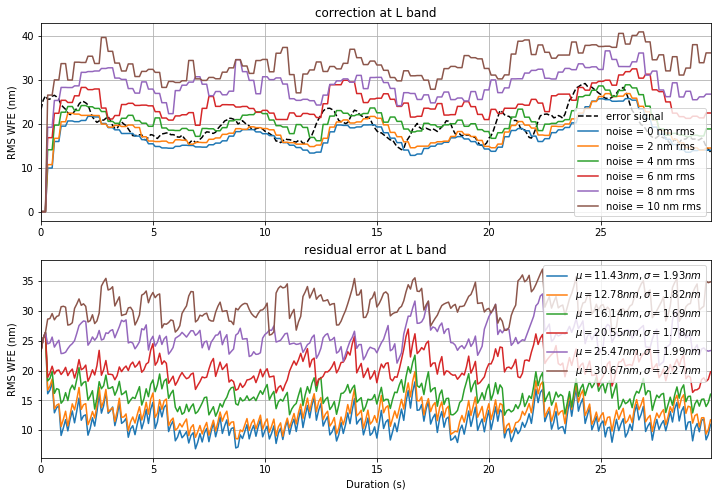

In [27]:
plot_integ_noise(nframes, range(3,100), 'L', nLF=3, nHF=3, G=.4)

### Zernikes 4-100 at 1 Hz (G = 0.4)

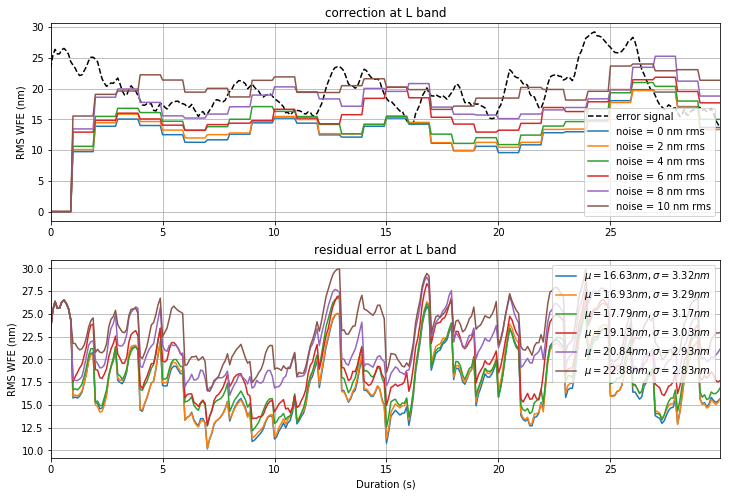

In [28]:
plot_integ_noise(nframes, range(3,100), 'L', nLF=10, nHF=10, G=.4)

# 5/ Closed-loop + lag

In [29]:
for lag in [0, 5, 10, 15, 20, 25, 30]:
    get_zpols_integ_lag(zpols, 1, 1, 0.4, lag)
    get_zpols_integ_lag(zpols, 3, 3, 0.4, lag)
    get_zpols_integ_lag(zpols, 10, 10, 0.4, lag)

already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1_G_0.4_lag_0.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_3_nHF_3_G_0.4_lag_0.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_10_nHF_10_G_0.4_lag_0.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1_G_0.4_lag_5.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_3_nHF_3_G_0.4_lag_5.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_10_nHF_10_G_0.4_lag_5.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1_G_0.4_lag_10.fits
already exists: wv/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_3_nHF_3_G_0.4_lag_10.fits
already ex

### Tip-tilt at 10 Hz (G = 0.4)

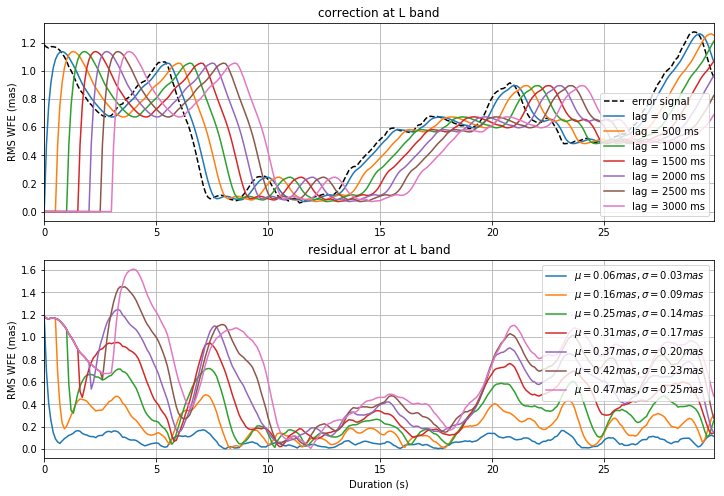

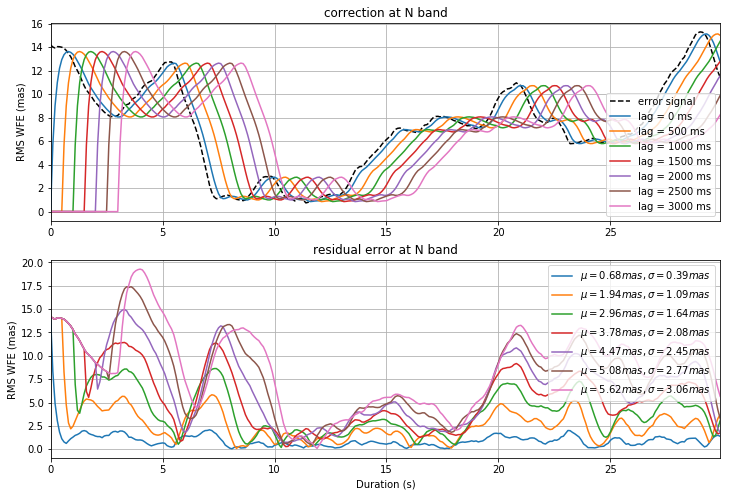

In [30]:
plot_integ_lag(nframes, range(1,3), 'L', nLF=1, nHF=1, G=.4, yunits='mas')
plot_integ_lag(nframes, range(1,3), 'N', nLF=1, nHF=1, G=.4, yunits='mas')

### Tip-tilt at 3.33 Hz (G = 0.4)

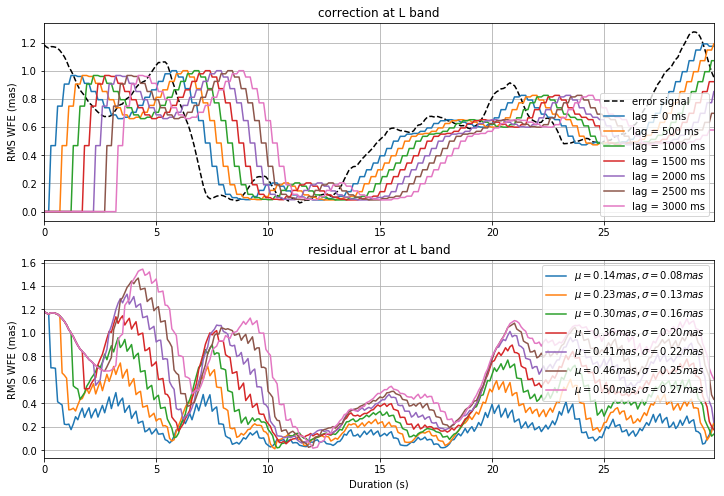

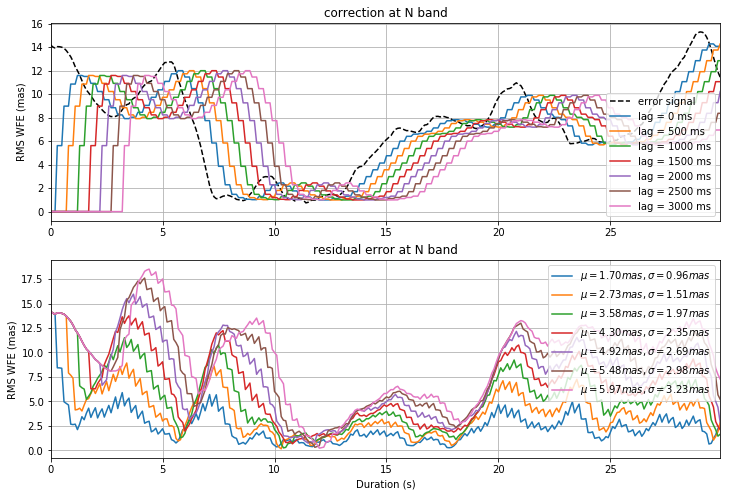

In [31]:
plot_integ_lag(nframes, range(1,3), 'L', nLF=3, nHF=3, G=.4, yunits='mas')
plot_integ_lag(nframes, range(1,3), 'N', nLF=3, nHF=3, G=.4, yunits='mas')

### Tip-tilt at 1 Hz (G = 0.4)

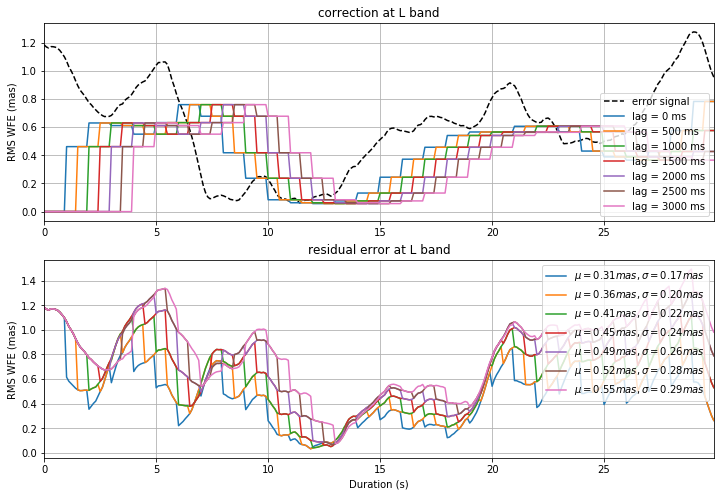

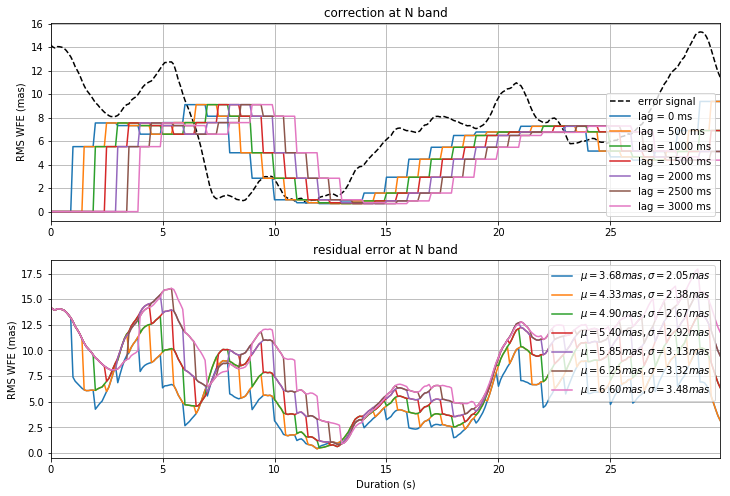

In [32]:
plot_integ_lag(nframes, range(1,3), 'L', nLF=10, nHF=10, G=.4, yunits='mas')
plot_integ_lag(nframes, range(1,3), 'N', nLF=10, nHF=10, G=.4, yunits='mas')

### Zernikes 4-100 at 1 Hz (G = 0.4)

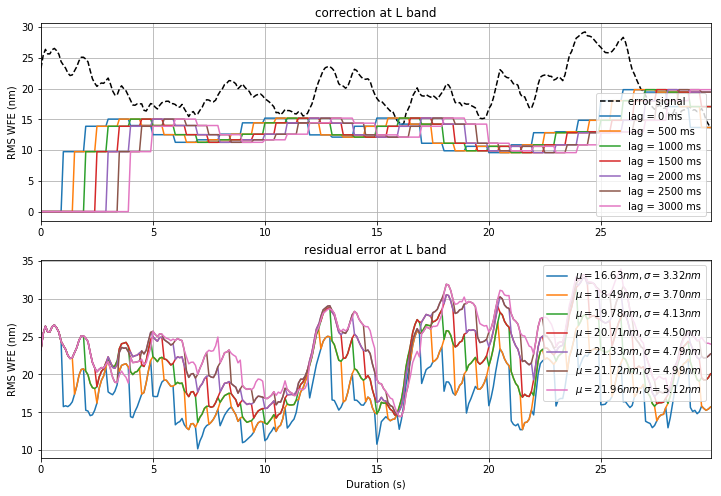

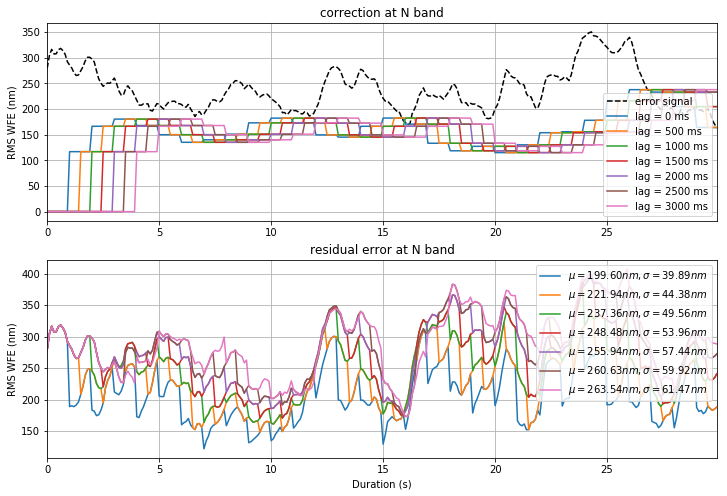

In [33]:
plot_integ_lag(nframes, range(3,100), 'L', nLF=10, nHF=10, G=.4)
plot_integ_lag(nframes, range(3,100), 'N', nLF=10, nHF=10, G=.4)

### Zernikes 4-100 at 3.33 Hz (G = 0.4)

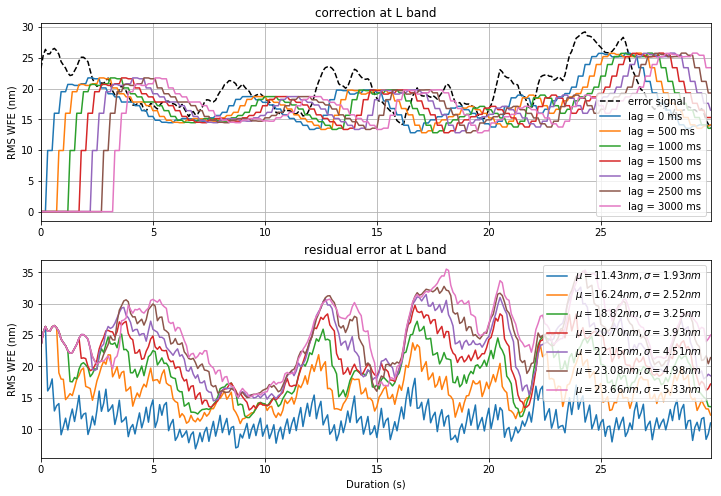

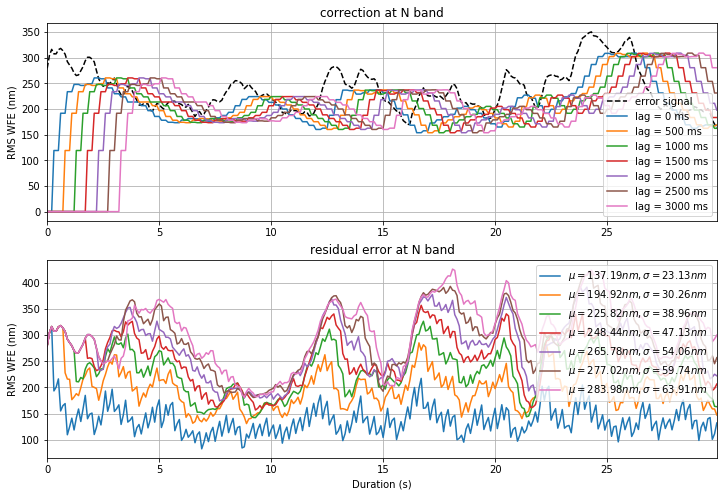

In [34]:
plot_integ_lag(nframes, range(3,100), 'L', nLF=3, nHF=3, G=.4)
plot_integ_lag(nframes, range(3,100), 'N', nLF=3, nHF=3, G=.4)

### Zernikes 4-100 at 10 Hz (G = 0.4)

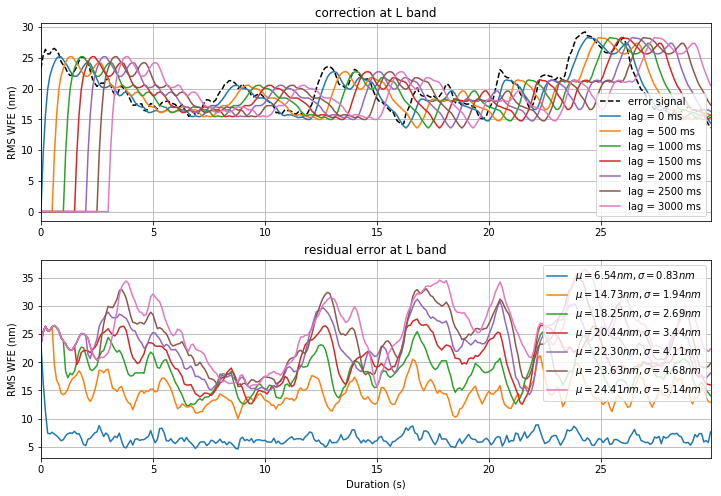

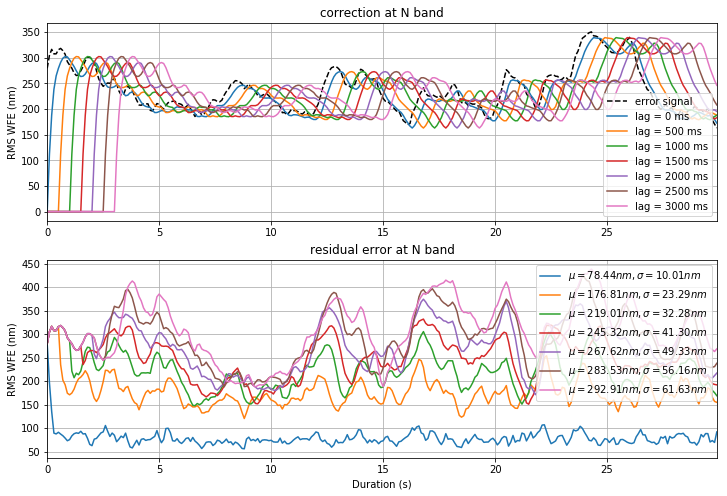

In [35]:
plot_integ_lag(nframes, range(3,100), 'L', nLF=1, nHF=1, G=.4)
plot_integ_lag(nframes, range(3,100), 'N', nLF=1, nHF=1, G=.4)